# Node Clustering in Graphs - Citation Network

The data is a citation network. Each node is a paper, and an edge indicates the relationship between two papers. The network has extremely sparse structure so we also use text information for each paper, i.e., the title of each paper. The data includes document title, edges, and class labels.

Node clustering in graphs is a useful process for knowledge discovery of communities or network structures. We are presented with a disconnected citation network of nodes, which are papers, and edges, which represent links between papers. We also document information and labels of nodes. Our aim is to cluster the nodes such that the normalised mutual information (NMI) score in relation to the labels, is  as high as possible, indicating information about the clusters. We will consider spectral clustering and Node2Vec approaches to graph clustering but first touch upon sentence vectors.

In [ ]:
# !pip install Node2Vec
# !python -m spacy download en_core_web_md
# !python -m spacy download en_core_web_lg

## Libraries

In [ ]:
import numpy as np
from itertools import product
import random
from math import log
import pickle
import time
import collections

import scipy as sp
import scipy.sparse.linalg as linalg
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
import networkx as nx
from node2vec import Node2Vec
import spacy

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline

## Create a network graph from input data

Create the graph by reading in the data and pre-processing it:

In [329]:
# Read edge data
with open('adjedges.txt') as f:
    lines = f.readlines()

In [330]:
# Arrange the edge data so that each edge is a tuple of two nodes
edge_list = []
for line in lines:
    if len(line.split()) > 1:
        for node in line.split():
            # If node ID is not the first in the line
            if node != line.split()[0]:
                # Create tuples representing an edge between first node and given node
                edge_list.append((int(line.split()[0]), int(node)))

In [331]:
# Read label data
with open('labels.txt') as f:
    labels = f.readlines()
for i in range(len(labels)):
    labels[i] = labels[i].strip().split()
    for j in range(len(labels[i])):
        # Set node and label to integer
        labels[i][j] = int(labels[i][j])

In [332]:
# Read docs data
with open('docs.txt', encoding='utf-8') as f:
    docs = f.readlines()
for i in range(len(docs)):
    docs[i] = docs[i].strip().split(' ', 1)
    for j in range(len(docs[i])):
        # Set node to integer
        docs[i][0] = int(labels[i][0])

In [333]:
# Create new directed and undirected graphs
g = nx.Graph()
dg = nx.DiGraph()
g.add_nodes_from([node[0] for node in labels])
dg.add_nodes_from([node[0] for node in labels])

In [334]:
# Add label and doc title attributes to nodes
for label, doc in zip(labels, docs):
    # Undirected graph
    g.nodes[label[0]]['label'] = label[1]
    g.nodes[doc[0]]['title'] = doc[1]
    
    # Directed graph
    dg.nodes[label[0]]['label'] = label[1]
    dg.nodes[doc[0]]['title'] = doc[1]

In [335]:
# Count the number of nodes
len(g.nodes())

18720

In [336]:
# Add edges to network (creating some new nodes in the process that have no  label or doc attribute)
g.add_edges_from([edge for edge in edge_list])
dg.add_edges_from([edge for edge in edge_list])

In [337]:
# Check number of edges
print(f'Number of edges provided in the data: {len(edge_list)}')
print(f'Number of unique edges provided in the data: {len(set(edge_list))}')
print(f'Number of edges in undirected graph: {len(g.edges())}')
print(f'Number of edges in directed graph: {len(dg.edges())}')

Number of edges provided in the data: 54370
Number of unique edges provided in the data: 54001
Number of edges in undirected graph: 53965
Number of edges in directed graph: 54001


There were a few duplicate edges in the data. Further, there were some edges that are duplicates if the graph is undirected (i.e. the order of the two nodes is switched around).

In [338]:
# Count the nodes again
len(g.nodes()) 

36928

In [339]:
# Check if graph is connected
nx.number_connected_components(g)

10440

The number of components in the graph is very large relative to the number of nodes, meaning there are  alot of nodes with a degree of 0 or 1 (all the unlabelled nodes came from the edge data so more than half of those 18k or so must have at least 1 edge).

In [342]:
# View number of nodes with k degrees for all degrees k in the graph
deg_count = {}
for node in g.nodes():
    if len(list(g.neighbors(node))) not in deg_count.keys():
        deg_count[len(list(g.neighbors(node)))] = 1
    else:
        deg_count[len(list(g.neighbors(node)))] += 1
deg_count = collections.OrderedDict(sorted(deg_count.items()))

print(deg_count)

OrderedDict([(0, 8651), (1, 12495), (2, 5137), (3, 2738), (4, 1698), (5, 1278), (6, 822), (7, 698), (8, 493), (9, 438), (10, 339), (11, 266), (12, 263), (13, 198), (14, 185), (15, 136), (16, 146), (17, 126), (18, 87), (19, 71), (20, 69), (21, 54), (22, 64), (23, 48), (24, 36), (25, 32), (26, 34), (27, 30), (28, 21), (29, 23), (30, 27), (31, 15), (32, 14), (33, 13), (34, 11), (35, 9), (36, 10), (37, 7), (38, 11), (39, 8), (40, 6), (41, 8), (42, 6), (43, 8), (44, 4), (45, 6), (46, 8), (47, 4), (49, 3), (50, 3), (51, 3), (52, 3), (53, 4), (54, 4), (55, 2), (56, 1), (57, 4), (58, 3), (59, 5), (60, 2), (61, 2), (62, 1), (63, 1), (64, 2), (65, 1), (66, 2), (69, 2), (73, 2), (74, 1), (75, 1), (76, 1), (79, 2), (81, 1), (82, 3), (89, 1), (91, 1), (94, 1), (99, 2), (101, 1), (102, 1), (115, 1), (121, 1), (123, 1), (142, 2), (149, 1), (150, 1), (161, 1), (162, 1), (204, 1), (270, 1)])


A lot of nodes without connections, representing a large proportion of the connected components. An even larger number of nodes have only 1 connection (A number of these would probably represent the same edge between two nodes that represent an entire component).

In [343]:
# Show the number of nodes in each component
cc = nx.connected_components(g) # generator
subgraph_sizes = [len(s) for s in cc]
subgraph_sizes.sort(reverse=True)
print(subgraph_sizes)

[20901, 98, 68, 63, 51, 49, 44, 42, 39, 39, 35, 32, 29, 28, 28, 27, 26, 23, 23, 23, 22, 21, 21, 21, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

There is one main component containing more than half of all nodes with no other component containing more than 100 nodes. 8,651 of the 10,440 components consist of a single node.

In [344]:
# Get node degrees of each node in the graph
node_degrees = [d for (n, d) in nx.degree(g)]

# Get the number of nodes assigned to each label
label_sizes = [(len([node for node in labels if node[1]==i])) for i in range(5)]

# Get average degree of nodes assigned to each label
l = np.cumsum([label_sizes]).tolist() + [0]
for i in range(len(label_sizes)):
    print(f'Label {i} average degree: {round(sum(node_degrees[l[i-1]:l[i]]) / label_sizes[i], 2)}')

Label 0 average degree: 0.65
Label 1 average degree: 9.52
Label 2 average degree: 1.14
Label 3 average degree: 5.66
Label 4 average degree: 0.94


From the labels data, label 1 nodes are highly connected and label 3 nodes are also quite well connected while labels 1 and 4 have average degrees of less than 1, so there are obviously a number of unconnected nodes with those labels. Label 2 nodes also have quite a low average degree.

## K-Core

Given the way the true labels are spread out throughout the network, it is worth seeing how a k-core decomposition performs. the k-core of a node is a measure of its central connectivity. The more highly connected a node is to other highly connected nodes, the higher its k-core will be. For example, a k-core of 9 would mean that if all nodes and edges were removed from a graph such that all remaining nodes have a degree of 9 or more, then all of the nodes in that graph would have a k-core of at least 9.

In [345]:
# Get and display the k-core of all nodes
core_dec = nx.core_number(g)
print(dict(sorted(core_dec.items(), key=lambda item: item[1], reverse=True)))

{62008201: 10, 804472: 10, 52569433: 10, 28440365: 10, 8430593: 10, 8783797: 10, 45230356: 10, 74407723: 10, 66782210: 10, 74042313: 10, 32149774: 10, 46375053: 10, 70475360: 10, 7004185: 10, 21531357: 10, 44661285: 10, 27056939: 10, 75886466: 10, 67262751: 10, 46846884: 10, 40506050: 10, 71898980: 10, 36136392: 10, 19360340: 10, 44856211: 10, 64575639: 10, 18133625: 10, 73867521: 10, 37360932: 10, 66677519: 10, 40194467: 10, 23253203: 10, 7360966: 10, 74399524: 10, 45397645: 10, 45745895: 10, 53661890: 10, 36217199: 10, 50343530: 10, 13096780: 10, 74093670: 10, 1244087: 10, 33197950: 10, 51132150: 10, 52363998: 10, 73394622: 10, 5053246: 10, 77412495: 10, 40515634: 10, 53675738: 10, 60009883: 10, 51653106: 10, 26373821: 10, 62693505: 10, 58502443: 10, 55236604: 10, 7144745: 10, 62646719: 10, 65308522: 10, 63179878: 10, 45759599: 10, 37258976: 10, 17910901: 10, 78373620: 10, 45226342: 10, 33790825: 10, 65434837: 10, 65694435: 10, 67128561: 10, 25668370: 10, 45227747: 10, 7012511: 9, 12

The maximum k-core in the graph is 10.

In [347]:
# Calculate the NMI
normalized_mutual_info_score(list(core_dec.values())[:len(labels)], [i[1] for i in labels])

0.27303130645270424

As there is some correlation between node connectivity amongst the labels, the k-core decomposition is able to quantify some amount of information about the groups of nodes.

## Spectral clustering

To use spectral clustering we first need to build a Laplacian matrix, which will be a matrix representation of the graph. We take the degree of each node as the diagonal matrix then subtract from it the adjacency matrix, which is a matrix of 1s representing edges between two nodes and 0s otherwise. The result is the Laplacian matrix, which will have degrees of nodes down the diagonal and negative 1s for adjacent nodes.

In [348]:
# Get laplacian matrix L from graph
L = nx.laplacian_matrix(g).astype(float)

The laplacian matrix is then decomposed to get the eigenvalues and eigenvectors.

In [402]:
%%time
# Run decomposition multiple times to account for randomness
eigen_list = []
for i in range(10):
    np.random.seed(i)
    v0 = np.random.rand(min(L.shape))
    w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM', v0=v0)
    eigen_list.append(v*w)

Wall time: 1h 35min 1s


In [442]:
def repeat_kmeans(embeddings, n_clusters=5, n_init=10, times=10):
    '''Run kmeans multiple times and return the average result'''
    
    results = []
    for i in range(times):
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=n_init, random_state=i)
        kmeans.fit_predict(embeddings)
        centroids = kmeans.cluster_centers_
        pred_labels = kmeans.labels_
        error = kmeans.inertia_
        NMI_score = normalized_mutual_info_score([i[1] for i in labels], pred_labels.tolist()[:len(labels)])
        results.append(NMI_score)
    
    return sum(results)/len(results), np.std(np.array(results)), pred_labels

In [443]:
# Run repeat_kmeans multiple times for each decomposition
model_kmeans = []
for X in eigen_list:
    model_kmeans.append(repeat_kmeans(X)[0])

In [444]:
spect_mean_nmi = sum(model_kmeans)/len(model_kmeans)
spect_std_nmi = np.std(np.array(model_kmeans))

print(f'Spectral clustering average NMI: {round(spect_mean_nmi, 4)} +/- {round(spect_std_nmi, 4)} std. dev')

Spectral clustering average NMI: 0.1086 +/- 0.0671 std. dev


Spectral clustering did not perform particularly well and is quite sensitive to the eigenvectors and eigenvalues obtained from the decomposition process as evidenced by the standard deviation. The kmeans algorithm was run with multiple centroid intialisations for each iteration so there is reduced variability in its output.

## Sentence Vectors

As the network is quite sparse and disjointed, we will also try to cluster the nodes using the text from `docs.txt`. We will use spaCy's pretrained nlp english language model.

In [421]:
# Get language objects for nlp from node doc text
nlp = spacy.load("en_core_web_lg")

In [422]:
# Get language objects from docs text
nlp_docs = [(doc[0], nlp(doc[1])) for doc in docs]

In [425]:
# Get sentence embeddings for each node in docs
sent_emb = [doc[1].vector for doc in nlp_docs]

The sentence embeddings here are simply just the average of the word embeddings for each node. We can again apply kmeans clustering on the sentence embeddings.

In [815]:
sv_mean_nmi, sv_std_nmi, sv_pred_labels = repeat_kmeans(sent_emb)

print(f'Sentence Vectors average NMI: {round(sv_mean_nmi, 4)} +/- {round(sv_std_nmi, 4)} std. dev')

Sentence Vectors average NMI: 0.275 +/- 0.0023 std. dev


Sentence Vectors perform much better than spectral clustering. The NMI is similar to k-core. We can visualise the clusters using t-distributed stochastic neighbor embedding to reduce the dimensionality.

In [823]:
tsne = TSNE(n_components=2, random_state=0, perplexity=100, init='random', learning_rate='auto')
embeddings_2d = tsne.fit_transform(np.array(sent_emb))

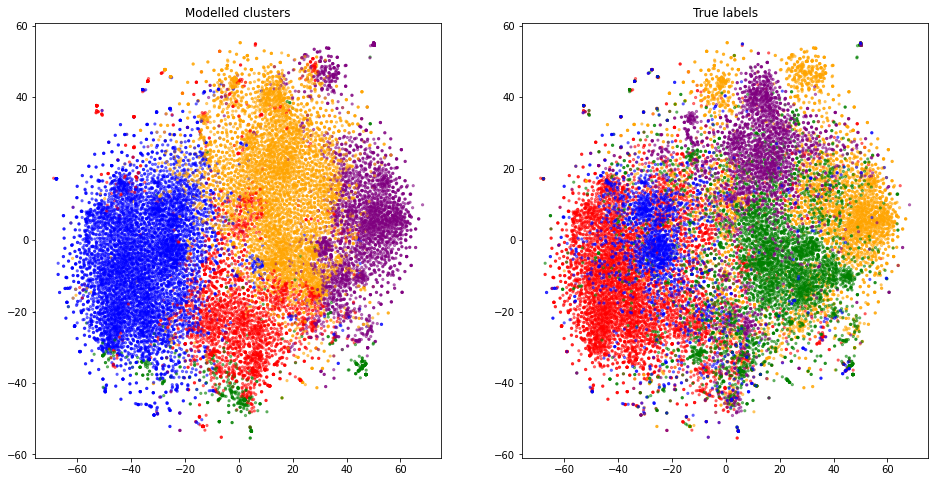

In [825]:
figure = plt.figure(figsize=(16, 8))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

colours = ['red', 'orange', 'green', 'purple', 'blue']
node_colours = [colours[label] for label in sv_pred_labels]
ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=node_colours, alpha=0.5, s=5)
node_colours = [colours[label] for label in [i[1] for i in labels]]
ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=node_colours, alpha=0.5, s=5)

# Add titles
ax1.title.set_text('Modelled clusters')
ax2.title.set_text('True labels')

On the left we can see that how 4 clusters have been allocated with a 5th green cluster be rather nondistinct. The true labels on the right show much more overlap as the red and blue clusters overlap a lot and the purple, green and orange clusters also have a reasonable amount of overlap. We can also output the numerical distribution of classes relative to the true labels:

In [818]:
def cluster_groups(predicted_labels, k=5):
    '''See how nodes are clustered compared to labels for k clusters'''
        
    # Get the index range of labels from labels.txt
    label_sizes = [(len([node for node in labels if node[1]==i])) for i in range(5)]
    label_range = [0] + np.cumsum([label_sizes]).tolist()

    # View breakdown of clustering
    for i in range(len(label_range)-1):
        j = i+1
        print(f'From {label_range[i]} to {label_range[j]} (label {i}):\n')
        for x in range(k):
            print(f'{x} {predicted_labels.tolist()[label_range[i]:label_range[j]].count(x)}')
        print('')

In [817]:
cluster_groups(sv_pred_labels)

From 0 to 5860 (label 0):

0 886
1 369
2 227
3 70
4 4308

From 5860 to 9801 (label 1):

0 471
1 1163
2 50
3 2105
4 152

From 9801 to 14222 (label 2):

0 1078
1 2029
2 180
3 777
4 357

From 14222 to 16925 (label 3):

0 277
1 2093
2 41
3 141
4 151

From 16925 to 18720 (label 4):

0 221
1 109
2 56
3 45
4 1364



The model has clustered most of the nodes from true labels 0 and 4 into the one cluster but are otherwise quite separate from the other 3 clusters. Cluster 2 has very few nodes allocated to it while the labels 1, 2 and 3 have quite a high number of nodes that were allocated to cluster 1.

To make use of the textual data about nodes, the spaCy pretrained English language model was used to embed each line of text as a vector. Each sentence embedding was the average of the word embedding values that made up that sentence. These embeddings were then used in the k-means clustering algorithm to find clusters, resulting in an NMI score of 0.275. The advantage to using this algorithm is that it does not rely on the graph structure and thus is not impacted by the data sparsity and disconnected nature of the graph.

## Modify graph connectivity

Instead of using the language model directly for clustering we can use it to modify the graph so that it is connected. We can find nodes that are not connected to the largest component of the graph and create  new edges with the most similar nodes until the whole graph is connected.

In [487]:
# Create a new copy of the graph
gc = g.copy()

# While graph is not connected
while nx.number_connected_components(gc) > 1:
    
    # Create connected components generator
    cc = nx.connected_components(gc)
    # Get the set of nodes that make up the largest component in the graph
    largest_component = max([s for s in cc], key=len)
    # Create list of nodes (and their nlp language object from text) that aren't in the largest component
    subset_docs = [(doc[0], nlp(doc[1])) for doc in docs if doc[0] not in largest_component]
    
    # For documents not in the main subgraph
    for doc1 in nlp_docs:
        if doc1[0] not in largest_component:
            similarity_scores = []
            for doc2 in nlp_docs:
                similarity_scores.append((doc2[0], doc1[1].similarity(doc2[1])))
            # Reverse sort on similarity score
            similarity_scores.sort(reverse=True, key=lambda x: x[1])
            # Check similarity scores from highest to lowest and best new edge
            for node in similarity_scores:
                # If the edge does not exist in the graph and edge is not a loop, add it then stop
                if not gc.has_edge(doc1[0], node[0]) and doc1[0] != node[0]:
                    gc.add_edge(doc1[0], node[0])
                    break

It was observed that the average degree of nodes differed drastically depending on the label. Nodes with label 3 and in particular 1, were much more highly connected whereas nodes with labels 0, 2 or 4 were often unconnected. In order to provide a fully connected graph, the spaCy English language model was also used to find similar sentences from the docs file, which were used to create new links in the graph. Two connected graphs were created this way; one in which it was ensured that every node had a degree of at least one, with additional edges added until the graph was connected (graph ‘gc’); the other had a minimum of degree 5 for every node that had label and text metadata (graph ‘gc2’).

## Graph embedding with Node2Vec

Node2Vec is based on Word2Vec in that nodes in node2vec are regarded in the same way that words are in word2vec. Nodes are embedded into vectors, taking into account other nodes in the neighbourhood on a random walk, which are connected by edges. In word2vec, words in a sentence are connected based on the order of the words in that sentence and a window size. Random walks are the way nodes are traversed, similar to words in a sentence in word2vec. 

Node2Vec uses biased random walks whereby we can specify weighting the walks to be more local or my global. The node2vec model hyperparameters here have been set to favour more global traversal, known as a depth-first search.

Below we embed the graph using node2vec. As it takes a long time to run we only run it once.

In [524]:
# Pre-compute the probabilities and generate walks :
node2vec = Node2Vec(gc, dimensions=64, walk_length=30, num_walks=200, p=3, q=0.5, workers=1, seed=0)
# Embed the nodes
model = node2vec.fit(window=10, min_count=1, batch_words=1)

In [546]:
# # Save the model
# pickle_out = open("dfs_200_walks.pickle", "wb")
# pickle.dump(model, pickle_out)
# pickle_out.close()

In [527]:
# Load model
pickle_in = open("dfs_200_walks.pickle", "rb")
model = pickle.load(pickle_in)
pickle_in.close()

In [534]:
# Get all node embeddings
n2v_emb = np.array([model.wv[str(x)] for x in gc.nodes])

In [552]:
# Now use kmeans to cluster
n2v_mean_nmi, n2v_std_nmi, n2v_pred_labels = repeat_kmeans(n2v_emb)

print(f'n2v average NMI: {round(n2v_mean_nmi, 4)} +/- {round(n2v_std_nmi, 4)} std. dev')

n2v average NMI: 0.3075 +/- 0.0003 std. dev


In [553]:
# kmeans clustering, ignoring unlabelled nodes when performing kmeans
n2v_mean_nmi, n2v_std_nmi, n2v_pred_labels = repeat_kmeans(n2v_emb[:len(labels)])

print(f'n2v average NMI: {round(n2v_mean_nmi, 4)} +/- {round(n2v_std_nmi, 4)} std. dev')

n2v average NMI: 0.3214 +/- 0.004 std. dev


Node2Vec with new edges from sentence similarity has performed slightly better than sentence vectors alone. What about spectral clustering?

## Spectral clustering on connected graph

In [772]:
# Get laplacian matrix L from graph
L = nx.laplacian_matrix(gc).astype(float)

In [773]:
%%time
# Run decomposition multiple times to account for randomness
eigen_list_2 = []
for i in range(10):
    np.random.seed(i)
    v0 = np.random.rand(min(L.shape))
    w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM', v0=v0)
    eigen_list_2.append(v*w)

Wall time: 57min 53s


In [799]:
# Run repeat_kmeans multiple times for each decomposition
spc2_kmeans = []
for X in eigen_list_2:
    spc2_kmeans.append(repeat_kmeans(X, n_clusters=5)[0])

In [800]:
# Display mean and st. dev
spect2_mean_nmi = sum(spc2_kmeans)/len(spc2_kmeans)
spect2_std_nmi = np.std(np.array(spc2_kmeans))

print(f'Spectral clustering average NMI: {round(spect2_mean_nmi, 4)} +/- {round(spect2_std_nmi, 4)} std. dev')

Spectral clustering average NMI: 0.2913 +/- 0.0 std. dev


In [802]:
_, _, spect2_pred_labels = repeat_kmeans(eigen_list_2[-1])

In [831]:
tsne = TSNE(n_components=2, random_state=0, perplexity=100, init='random', learning_rate='auto')
spc_emb_2_2d = tsne.fit_transform(np.array(eigen_list_2[-1][:18720]))

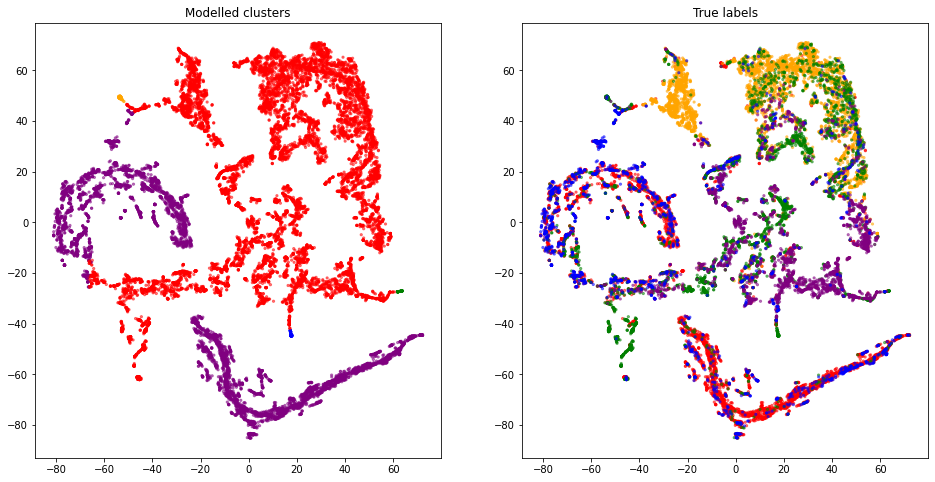

In [833]:
figure = plt.figure(figsize=(16, 8))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

colours = ['red', 'orange', 'green', 'purple', 'blue']
node_colours = [colours[label] for label in spect2_pred_labels[:18720]]
ax1.scatter(spc_emb_2_2d[:, 0], spc_emb_2_2d[:, 1], c=node_colours, alpha=0.5, s=5)
node_colours = [colours[label] for label in [i[1] for i in labels]]
ax2.scatter(spc_emb_2_2d[:, 0], spc_emb_2_2d[:, 1], c=node_colours, alpha=0.5, s=5)

# Add titles
ax1.title.set_text('Modelled clusters')
ax2.title.set_text('True labels')

There are obvious problems with the spectral clustering here. Spectral clustering is good at finding non-linear clusters and the two distinct clusters it has identified are distinctively different in the true labels, but they are made up of 2 or 3 different labels. The spectral clustering has almost completely omitted the other three clusters.

In [811]:
cluster_groups(spect2_pred_labels)

From 0 to 5860 (label 0):

0 1386
1 2
2 13
3 4456
4 3

From 5860 to 9801 (label 1):

0 3935
1 0
2 0
3 6
4 0

From 9801 to 14222 (label 2):

0 3825
1 61
2 31
3 448
4 56

From 14222 to 16925 (label 3):

0 2668
1 2
2 1
3 32
4 0

From 16925 to 18720 (label 4):

0 507
1 2
2 4
3 1282
4 0



## Increase connectivity of the graph

Next we'll try adding even more new edges to the original graph so that every node has at least degree 5.

In [540]:
# Create list of text from nlp_docs
nlp_text = [text[1] for text in nlp_docs]

# Create nested list of text similarities for all nodes
all_scores = [[t1.similarity(t2) for t2 in nlp_text] for t1 in nlp_text]

# Cast as a matrix
similarities_mat = np.zeros((len(nlp_text),len(nlp_text)))
for i, v in enumerate(all_scores):
    similarities_mat[i] = v

In [541]:
# Create a new copy of the graph
gc2 = g.copy()

# Create connected components generator
cc = nx.connected_components(gc2)
# Get the set of nodes that make up the largest component in the graph
largest_component = max([s for s in cc], key=len)

# Ensure every node with label/text data is of at least degree 5
for x in range(1,6):
    for i in range(len(nlp_docs)):
        # If node has fewer than x edges or is separate from the largest component
        if gc2.degree(nlp_docs[i][0]) < x or nlp_docs[i][0] not in largest_component:
            similarity_ranks = np.argsort(similarities_mat[i])[::-1]
            for j in similarity_ranks:
                # If the edge does not exist in the graph and edge is not a loop, add it then stop
                if not gc2.has_edge(nlp_docs[i][0], nlp_docs[j][0]) and nlp_docs[i][0] != nlp_docs[j][0]:
                    gc2.add_edge(nlp_docs[i][0], nlp_docs[j][0])
                    # Stop after adding an edge
                    break

## Node2Vec embeddings on more highly connected graph

In [545]:
# Pre-compute the probabilities and generate walks :
node2vec = Node2Vec(gc2, dimensions=128, walk_length=40, num_walks=200, p=3, q=0.5, workers=1, seed=0)
# Embed the nodes
model_2 = node2vec.fit(window=10, min_count=1, batch_words=1)

In [547]:
# # Save the model
# pickle_out = open("dfs_gc2_model.pickle", "wb")
# pickle.dump(model2, pickle_out)
# pickle_out.close()

In [549]:
# Load model
pickle_in = open("dfs_gc2_model.pickle", "rb")
model_2 = pickle.load(pickle_in)
pickle_in.close()

In [550]:
# Get all node embeddings
n2v_emb_2 = np.array([model_2.wv[str(x)] for x in gc2.nodes])

In [554]:
# Apply kmeans
n2v_2_mean_nmi, n2v_2_std_nmi, n2v_2_pred_labels = repeat_kmeans(n2v_emb_2)

print(f'n2v_2 average NMI: {round(n2v_2_mean_nmi, 4)} +/- {round(n2v_2_std_nmi, 4)} std. dev')

n2v_2 average NMI: 0.4102 +/- 0.0031 std. dev


In [555]:
# Apply kmeans
n2v_2_mean_nmi, n2v_2_std_nmi, n2v_2_pred_labels = repeat_kmeans(n2v_emb_2[:len(labels)])

print(f'n2v_2 average NMI: {round(n2v_2_mean_nmi, 4)} +/- {round(n2v_2_std_nmi, 4)} std. dev')

n2v_2 average NMI: 0.4484 +/- 0.0002 std. dev


Adding more connectivity has improved the NMI by quite a bit.

In [746]:
cluster_groups(n2v_2_pred_labels)

From 0 to 5860 (label 0):

0 372
1 5129
2 69
3 117
4 173

From 5860 to 9801 (label 1):

0 2635
1 36
2 1061
3 80
4 129

From 9801 to 14222 (label 2):

0 1319
1 551
2 43
3 2042
4 466

From 14222 to 16925 (label 3):

0 134
1 76
2 23
3 166
4 2304

From 16925 to 18720 (label 4):

0 148
1 1536
2 19
3 27
4 65



Both the first and last group are mostly clustered together while some of the second and third groups have some overlap. They both split their nodes so that some are in a more isolated group and some overlap with each other. The second last group is quite pure. We can also look at this visually:

In [628]:
tsne = TSNE(n_components=2, random_state=0, perplexity=100, learning_rate='auto', init='random')
n2v_emb_2_2d = tsne.fit_transform(np.array(n2v_emb_2[:18720,]))

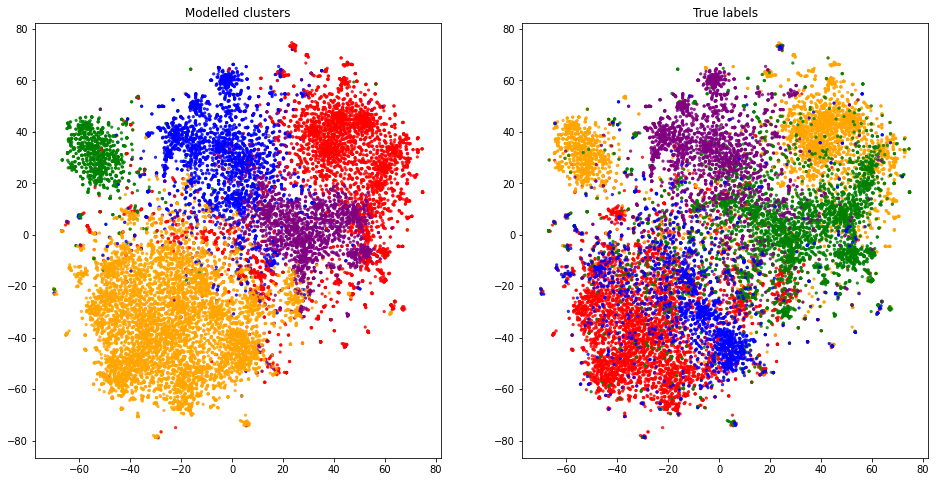

In [640]:
figure = plt.figure(figsize=(16, 8))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

colours = ['red', 'orange', 'green', 'purple', 'blue']
node_colours = [colours[label] for label in n2v_2_pred_labels]
ax1.scatter(n2v_emb_2_2d[:, 0], n2v_emb_2_2d[:, 1], c=node_colours, alpha=0.75, s=5)
node_colours = [colours[label] for label in [i[1] for i in labels]]
ax2.scatter(n2v_emb_2_2d[:, 0], n2v_emb_2_2d[:, 1], c=node_colours, alpha=0.75, s=5)

# Add titles
ax1.title.set_text('Modelled clusters')
ax2.title.set_text('True labels')

Some of the clusters match closely (the blue on the left with the purple on the right and the purple on the left with the green on the right). The orange cluster on the left is roughly equivalent to both the red and blue clusters on the right which has resulted in the additional green cluster on the left.

Node2Vec wasn’t trained on the original graph as many nodes would not be reachable on a random walk when the graph is disconnected. For graph gc, the node2vec model achieved an NMI of 0.3075 when k-means algorithm was carried out on all nodes and 0.3214 when k-means was applied only on labelled nodes (the unlabelled nodes receive embeddings so can still be clustered, but they cannot be evaluated). On gc2, the NMI for the node2vec model jumps to 0.4102 when unlabelled nodes are included in the k-means clustering and 0.4484 when the unlabelled nodes are excluded. 

Some of the issues observed with the clustering in gc2 were that the model could not differentiate label 0 from label 4 (cluster 1) well. It seems likely that the text in those document classes were similar enough that the NLP model could not differentiate between them. Given that these two labels were also the sparsest, there would have been quite a few edges created between nodes across these two labelled classes. This is backed up by the fact that the sentence vector model struggled with the same issue. Cluster 4 is very pure while cluster 0 is split across labels 2 and 3.  Labels 2 and 3 also have another cluster that some of their nodes were allocated to, which are purer (clusters 2 and 3).

## Spectral clustering on connected graph

In [843]:
# Get laplacian matrix L from more highly connected graph
L = nx.laplacian_matrix(gc2).astype(float)

In [901]:
%%time
# Run decomposition multiple times to account for randomness
eigen_list_3 = []
for i in range(10):
    np.random.seed(i)
    v0 = np.random.rand(min(L.shape))
    w,v = sp.sparse.linalg.eigsh(L, k=5, which='SM', v0=v0)
    eigen_list_3.append(v*w)

Wall time: 1min 17s


In [902]:
# Run repeat_kmeans multiple times for each decomposition
spc3_kmeans = []
for X in eigen_list_3:
    spc3_kmeans.append(repeat_kmeans(X, n_clusters=5)[0])

In [903]:
# Display mean and st. dev
spect3_mean_nmi = sum(spc3_kmeans)/len(spc3_kmeans)
spect3_std_nmi = np.std(np.array(spc3_kmeans))

print(f'Spectral clustering average NMI: {round(spect3_mean_nmi, 4)} +/- {round(spect3_std_nmi, 4)} std. dev')

Spectral clustering average NMI: 0.0012 +/- 0.0 std. dev


In [896]:
_, _, spect3_pred_labels = repeat_kmeans(eigen_list_3[-1], n_clusters=5)

In [897]:
tsne = TSNE(n_components=2, random_state=0, perplexity=100, init='random', learning_rate='auto')
spc_emb_3_2d = tsne.fit_transform(np.array(eigen_list_3[-1][:18720]))

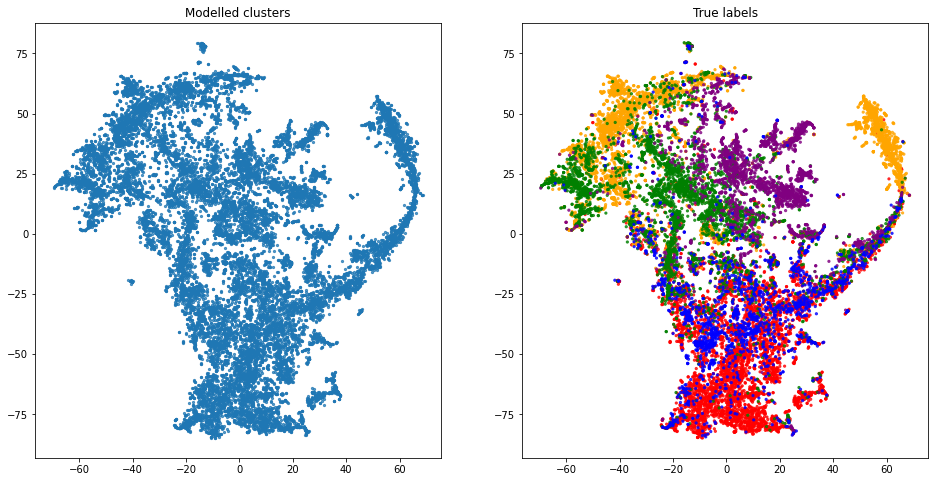

In [856]:
figure = plt.figure(figsize=(16, 8))
ax1 = figure.add_subplot(121)
ax2 = figure.add_subplot(122)

colours = ['red', 'orange', 'green', 'purple', 'blue']
node_colours = [colours[label] for label in pred_labels[:18720]]
ax1.scatter(spc_emb_3_2d[:, 0], spc_emb_3_2d[:, 1], alpha=0.75, s=5)
node_colours = [colours[label] for label in [i[1] for i in labels]]
ax2.scatter(spc_emb_3_2d[:, 0], spc_emb_3_2d[:, 1], c=node_colours, alpha=0.75, s=5)

# Add titles
ax1.title.set_text('Modelled clusters')
ax2.title.set_text('True labels')

Spectral clustering has allocated everything to one cluster even thought he true label does show some logical spatial clustering. Potenially, if many clusters were created, the NMI would improve but most clusters would be null clusters and likely the end result would still be that all or most of the data allocated to a couple of clusters.

For the unconnected graph, consisting of one large component and many small components, spectral clustering was highly sensitive to the random starting vector and performed quite poorly overall. On average it produced an NMI of 0.1086 with standard deviation of 0.0671. For graph gc, it consistently achieved an NMI of 0.2913, finding some interesting patterns that were unfortunately not isolated to one class of labelled data. For gc2, with 5 eigenvectors and 5 clusters, spectral clustering broke down completely. A lot of the eigenvectors produced were the same, resulting in embeddings that were close together and making it difficult for k-means to create distinct clusters without specifying a high number of clusters.

## View best set of clusters for each algorithm

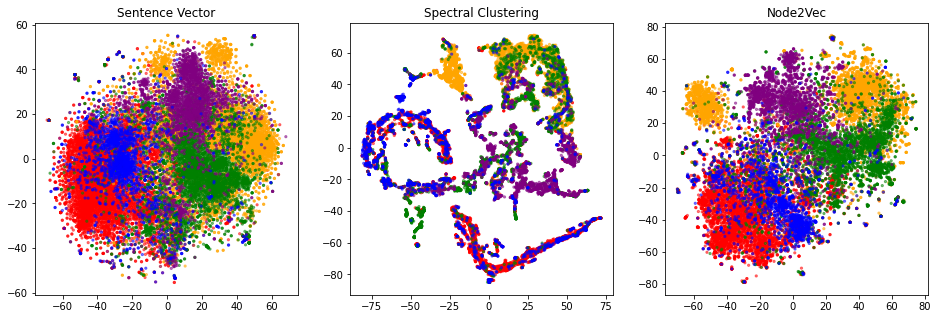

In [841]:
figure = plt.figure(figsize=(16, 5))
ax1 = figure.add_subplot(131)
ax2 = figure.add_subplot(132)
ax3 = figure.add_subplot(133)

colours = ['red', 'orange', 'green', 'purple', 'blue']
node_colours = [colours[label] for label in [i[1] for i in labels]]

ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=node_colours, alpha=0.5, s=5)
ax2.scatter(spc_emb_2_2d[:, 0], spc_emb_2_2d[:, 1], c=node_colours, alpha=0.5, s=5)
ax3.scatter(n2v_emb_2_2d[:, 0], n2v_emb_2_2d[:, 1], c=node_colours, alpha=0.5, s=5)

# Add titles
ax1.title.set_text('Sentence Vector')
ax2.title.set_text('Spectral Clustering')
ax3.title.set_text('Node2Vec')

When compared side by side, we can see that Node2Vec has the most distinct clusters.

The node2vec embeddings of the higher connectivity graph provided a much greater NMI than either the spectral clustering algorithm or sentence vectors. This could also be seen from the t-distributed stochastic neighbour embedding of the clusters, which showed a clearer distinction between the clusters. However, it is important to keep in mind that the Node2Vec models have a much more extensive training time due to the complex optimisation problem and calculation of many walks from each node. Despite this, due to the difference in results it is still recommended to use Node2Vec embeddings with k-means clustering as it provided a greater amount of information about the data.